In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import os
import sys
from pprint import pprint
from pylab import rcParams

In [2]:
sys.path.append("../")
import core.tools.json_rec as json_rec

In [3]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")

In [4]:
import tools
from typing import List, Tuple

In [5]:
now = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

### CONTROL PANEL

In [6]:
PATH_COL = tools.mkdirs(f"./saved/{now}")
pprint(PATH_COL)
PARAMS = dict(
    COL_NAME = "UNRATE",
    P = 36,
    NUM_TIME_STEPS = 36,
    D = 1,
    Q = None,
    NUM_INPUTS = 1,
    NUM_OUTPUTS = 1,
    # Training Config
    RNN_NEURONS = [256, 512, 1024],
    LR = 0.01,
    EPOCHS = None,
    CELL_TYPE = [tf.nn.rnn_cell.LSTMCell, tf.nn.rnn_cell.LSTMCell, tf.nn.rnn_cell.LSTMCell],
    PATIENT = 100,
    EPSILON = 1e-8
)

Creating directory: ./saved/2019-01-07_19:33:20
Creating directory: ./saved/2019-01-07_19:33:20/tensorboard
Creating directory: ./saved/2019-01-07_19:33:20/figures
Creating directory: ./saved/2019-01-07_19:33:20/numericals
{'BASE_PATH': './saved/2019-01-07_19:33:20',
 'FIG_PATH': './saved/2019-01-07_19:33:20/figures',
 'NUM_PATH': './saved/2019-01-07_19:33:20/numericals',
 'TB_PATH': './saved/2019-01-07_19:33:20/tensorboard'}


In [7]:
globals().update(PATH_COL)
globals().update(PARAMS)

In [8]:
json_param = PARAMS.copy()
if not isinstance(json_param["CELL_TYPE"], str):
    json_param["CELL_TYPE"] = [str(x) for x in json_param["CELL_TYPE"]]

In [9]:
json_param

{'COL_NAME': 'UNRATE',
 'P': 36,
 'NUM_TIME_STEPS': 36,
 'D': 1,
 'Q': None,
 'NUM_INPUTS': 1,
 'NUM_OUTPUTS': 1,
 'RNN_NEURONS': [256, 512, 1024],
 'LR': 0.01,
 'EPOCHS': None,
 'CELL_TYPE': ["<class 'tensorflow.python.ops.rnn_cell_impl.LSTMCell'>",
  "<class 'tensorflow.python.ops.rnn_cell_impl.LSTMCell'>",
  "<class 'tensorflow.python.ops.rnn_cell_impl.LSTMCell'>"],
 'PATIENT': 100,
 'EPSILON': 1e-08}

In [10]:
param_writer = json_rec.ParamWriter()
param_writer.write(json_param, file_dir=PATH_COL["BASE_PATH"] + "/params.json")
param_writer.write(PATH_COL, file_dir=PATH_COL["BASE_PATH"] + "/paths.json")

In [11]:
df = pd.read_csv("./data/UNRATE.csv", index_col=0, parse_dates=True)
# df["DATE"] = pd.to_datetime(df["DATE"])
df.columns = [COL_NAME]
print(df.dtypes)
df.head()
# month_df = df.resample("M").mean().head()

UNRATE    float64
dtype: object


,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [12]:
diff = df.diff()  #  Take the first order differenced.
diff.dropna(inplace=True)
slp = tools.gen_slp_sequential(diff, num_time_steps=P)

Failed time step ignored: 815
Failed time step ignored: 816
Failed time step ignored: 817
Failed time step ignored: 818
Failed time step ignored: 819
Failed time step ignored: 820
Failed time step ignored: 821
Failed time step ignored: 822
Failed time step ignored: 823
Failed time step ignored: 824
Failed time step ignored: 825
Failed time step ignored: 826
Failed time step ignored: 827
Failed time step ignored: 828
Failed time step ignored: 829
Failed time step ignored: 830
Failed time step ignored: 831
Failed time step ignored: 832
Failed time step ignored: 833
Failed time step ignored: 834
Failed time step ignored: 835
Failed time step ignored: 836
Failed time step ignored: 837
Failed time step ignored: 838
Failed time step ignored: 839
Failed time step ignored: 840
Failed time step ignored: 841
Failed time step ignored: 842
Failed time step ignored: 843
Failed time step ignored: 844
Failed time step ignored: 845
Failed time step ignored: 846
Failed time step ignored: 847
Failed tim

In [13]:
X, y, ts = tools.format_instances(slp)

num_instances=815, num_inputs=1, num_outputs=1, num_time_steps=36


In [14]:
(X_train, y_train, ts_train,
X_val, y_val, ts_val,
X_test, y_test, ts_test) = tools.split_dataset(X, y, ts)

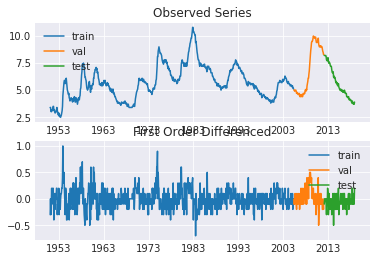

In [15]:
plt.close()
rcParams["figure.figsize"] = (32, 16)
ax1 = plt.subplot(2, 1, 1)
plt.title("Observed Series")
plt.plot(ts_train, df[COL_NAME][ts_train], label="train")
plt.plot(ts_val, df[COL_NAME][ts_val], label="val")
plt.plot(ts_test, df[COL_NAME][ts_test], label="test")
plt.legend()
plt.grid(True)

ax2 = plt.subplot(2, 1, 2)
rcParams["figure.figsize"] = (32, 16)
plt.title("First Order Differenced")
plt.plot(ts_train, y_train[:, -1, :], label="train")
plt.plot(ts_val, y_val[:, -1, :], label="val")
plt.plot(ts_test, y_test[:, -1, :], label="test")
plt.legend()
plt.grid(True)

plt.savefig(PATH_COL["FIG_PATH"] + "/raw.png", dpi=600)
plt.show()

In [16]:
# ax = plt.figure(figsize=(32,8))
# plt.title("Log")
# plt.plot(ts_train, np.log(y_train[:, -1, :]), label="train")
# plt.plot(ts_val, np.log((y_val[:, -1, :])), label="val")
# plt.plot(ts_test, np.log(y_test[:, -1, :]), label="test")
# plt.legend()
# plt.grid(True)
# plt.show()

In [17]:
tf.reset_default_graph()
# Build LSTM Neural Net
# Data IO Layers
with tf.name_scope("DATA_IO"):
    X = tf.placeholder(
        tf.float32,
        [None, NUM_TIME_STEPS, NUM_INPUTS],
        name="FEATURE"
    )
    y = tf.placeholder(
        tf.float32,
        [None, NUM_TIME_STEPS, NUM_OUTPUTS],
        name="LABEL"
    )

In [18]:
# Recurrent Structure.
# with tf.name_scope("RECURRENT"):
# if CELL_TYPE == "GRU":
#     cells = [
#         tf.nn.rnn_cell.GRUCell(
#             num_units=x,
#             name=f"GRU_LAYER_{i}")
#         for i, x in enumerate(RNN_NEURONS)
#     ]
# elif CELL_TYPE == "LSTM":
#     cells = [
#         tf.nn.rnn_cell.LSTMCell(
#             num_units=x,
#             name=f"LSTM_LAYER_{i}")
#         for i, x in enumerate(RNN_NEURONS)
#     ]
# else:
#     cells = [
#         Cell(
#             num_units=x,
#             name=f"RNN_LAYER_{i}")
#         for i, (Cell, x) in enumerate(zip(CELL_TYPE, x))
#     ]

cells = [
    Cell(
        num_units=x,
        name=f"RNN_LAYER_{i}")
    for i, (Cell, x) in enumerate(zip(CELL_TYPE, RNN_NEURONS))
]

multi_cell = tf.nn.rnn_cell.MultiRNNCell(cells)
outputs, state = tf.nn.dynamic_rnn(
    cell=multi_cell,
    inputs=X,
    dtype=tf.float32
)

In [19]:
# with tf.name_scope("OUTPUT"):
reg_outputs = tf.layers.dense(
    outputs,
    NUM_OUTPUTS,
    kernel_initializer=tf.random_normal_initializer(),
    bias_initializer=tf.random_normal_initializer(),
    activation=None,  # linear activation.
    name="OUTPUT_DENSE"
)
# W = tf.Variable(
#     tf.random_normal(
#     [RNN_NEURONS[-1], NUM_OUTPUTS],
#     name="OUTPUT_WEIGHT"
#     )
# )
# b = tf.Variable(
#     tf.random_normal(
#     [NUM_OUTPUTS, 1],
#     name="OUTPUT_BIAS"
#     )
# )
# reg_outputs = outputs @ W + b

In [20]:
with tf.name_scope("METRICS"):
#     loss = tf.losses.mean_squared_error(
#         labels=y,
#         predictions=reg_outputs,
#     )
    
    # Redundent losses to evaluate and ensure the correctness of
    # built-in losses function.
    loss = tf.reduce_mean(
        tf.square(y - reg_outputs),
        name="Red_MSE",
        axis=None
    )
    tf.summary.scalar("MSE", loss)
#     tf.summary.scalar("Red_MSE", loss2)

In [21]:
with tf.name_scope("OPTIMIZER"):
    optimizer = tf.train.AdamOptimizer(
        learning_rate=LR,
        name="OPTIMIZER"
    )
#     gvs = optimizer.compute_gradients(loss)
#     capped_gvs = [
#         (tf.clip_by_value(
#             grad, -1.0, 1.0), var)
#         for grad, var in gvs
#     ]
#     train = optimizer.apply_gradients(capped_gvs)
    train = optimizer.minimize(loss)

In [22]:
start = datetime.datetime.now()
counter = 0
val_mse = np.inf
if EPOCHS is None:
    EPOCHS = int(100000)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    merged_summary = tf.summary.merge_all()
    
    train_writer = tf.summary.FileWriter(PATH_COL["TB_PATH"] + "/train")
    val_writer = tf.summary.FileWriter(PATH_COL["TB_PATH"] + "/validation")
    
    train_writer.add_graph(sess.graph)
    for e in range(EPOCHS):
#         tools.progbar(e+1, EPOCHS, 30)
        sess.run(
            train,
            feed_dict={X: X_train, y: y_train}
        )
    
        if e % 5 == 0:
            tsum = sess.run(
                merged_summary,
                feed_dict={X: X_train, y: y_train}
            )
            vsum = sess.run(
                merged_summary,
                feed_dict={X: X_val, y: y_val}
            )
            train_writer.add_summary(tsum, e)
            val_writer.add_summary(vsum, e)
            
        # ==== Automatically Stop Training ====
        val_mse_last = val_mse
        train_mse = loss.eval(feed_dict={X: X_train, y: y_train})
        val_mse = loss.eval(feed_dict={X: X_val, y: y_val})
        if (val_mse_last - val_mse) < PARAMS["EPSILON"]:
            # if the improvement is less than epsilon.
            counter += 1
        else:
            counter -= 1
            counter = max(counter, 0)
        
        if counter >= PARAMS["PATIENT"]:
            print(f"Break training at epoch={e}")
            break
        # ==== End ====    
            
        if e % 100 == 0:
            print(f"Epoch={e}: train_MSE={train_mse}, val_MSE={val_mse}, current_patient={counter}")
            
    make_prediction = lambda data: sess.run(reg_outputs, feed_dict={X: data})
    pred_train = make_prediction(X_train)
    pred_val = make_prediction(X_val)
    pred_test = make_prediction(X_test)
print(f"Time taken: {datetime.datetime.now() - start}")

Epoch=0: train_MSE=135.3621368408203, val_MSE=168.69210815429688, current_patient=0
Epoch=100: train_MSE=0.11732931435108185, val_MSE=0.08383776247501373, current_patient=0
Epoch=200: train_MSE=0.048818837851285934, val_MSE=0.03691777214407921, current_patient=0
Epoch=300: train_MSE=0.04565301910042763, val_MSE=0.03520144149661064, current_patient=0
Epoch=400: train_MSE=0.04529929906129837, val_MSE=0.03504402935504913, current_patient=0
Epoch=500: train_MSE=0.045056115835905075, val_MSE=0.03493071347475052, current_patient=0
Epoch=600: train_MSE=0.04486018791794777, val_MSE=0.034835126250982285, current_patient=0
Epoch=700: train_MSE=0.04469718411564827, val_MSE=0.034749530255794525, current_patient=0


KeyboardInterrupt: 

In [ ]:
extract_last = lambda pred_combo: np.squeeze([x[-1] for x in pred_combo])
# NOTE: dfp stands for DataFrame of Prediction
dfp_train = pd.DataFrame(data=extract_last(pred_train), index=ts_train)
dfp_val = pd.DataFrame(data=extract_last(pred_val), index=ts_val)
dfp_test = pd.DataFrame(data=extract_last(pred_test), index=ts_test)

In [ ]:
pred_diff = pd.concat([dfp_train, dfp_val, dfp_test])
pred_diff.columns = [COL_NAME]

In [ ]:
pred_raw = tools.inv_diff(pred_diff, df)

In [ ]:
plt.close()
# ==== Raw ====
ax1 = plt.subplot(2, 1, 1)
rcParams["figure.figsize"] = (32, 16)
plt.title("Ground truth versus Prediction on Raw Series")
plt.plot(df, label="Observed", alpha=.6)
plt.plot(pred_raw, label="Prediction", alpha=.6)

plt.axvline(x=diff.index[len(X_train)+1], color="grey", alpha=.4, label="train-val boundary")
plt.axvline(x=diff.index[-len(X_test)+1], color="grey", alpha=.4, label="val-test boundary")
plt.grid(True)

ax1.set_xlabel("Date")
ax1.set_ylabel("UNRATE")
plt.legend()

# ==== First order differenced ====
ax2 = plt.subplot(2, 1, 2)
rcParams["figure.figsize"] = (32, 16)
plt.title("Ground truth versus Prediction on First Order Differenced")
plt.plot(diff, label="Observed(Ground Truth)", color="grey", alpha=.7)
plt.plot(dfp_train, label="Train", alpha=.7)
plt.plot(dfp_val, label="Validation", alpha=.7)
plt.plot(dfp_test, label="Test", alpha=.7)
plt.legend()

ax2.set_xlabel("Date")
ax2.set_ylabel("Change in UNRATE")
plt.grid(True)

plt.savefig(PATH_COL["FIG_PATH"] + "/prediction.png", dpi=600)
plt.show()

In [ ]:
pred_raw.to_csv(PATH_COL["NUM_PATH"] + "/pred_raw.csv")
dfp_train.to_csv(PATH_COL["NUM_PATH"] + "/dfp_train.csv")
dfp_val.to_csv(PATH_COL["NUM_PATH"] + "/dfp_val.csv")
dfp_test.to_csv(PATH_COL["NUM_PATH"] + "/dfp_test.csv")